In [143]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import pandas as pd

# Create a custom_scorer that is used for both inner and outer cv
def gini_scorer(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    gini = 2 * auc - 1
    return gini
custom_scorer = make_scorer(gini_scorer, greater_is_better=True, needs_proba=True)
estimator=lgb.LGBMClassifier(verbose=-1)


class FeatureSelector:
    def __init__(self, estimator, min_features_to_select=None, step=1, scoring=None, cv=None):
        """
        Initialize the FeatureSelector.

        Args:
            estimator: The estimator to be used for feature selection, e.g., a classifier or regressor.
            n_features_to_select: The number of features to select. If None, half of the features will be selected.
            step: The number of features to remove at each iteration (default is 1).
            cv: Cross-validation generator (default is StratifiedKFold with 5 folds).
        """
        self.estimator = estimator
        self.min_features_to_select = min_features_to_select
        self.step = step
        self.scoring = scoring
        self.cv = cv

    def select_features(self, X, y):
        """
        Select the best features using RFE (Recursive Feature Elimination) and cross-validation.

        Parameters:
            X: The feature matrix.
            y: The target values.

        Returns:
            selected_features: The selected feature indices.
        """
        self.rfecv = RFECV(estimator=self.estimator, 
                  min_features_to_select=self.min_features_to_select, 
                  step=self.step,
                  scoring=self.scoring,
                  cv=self.cv)
        selected_features = self.rfecv.fit(X, y).support_
        cv_score = np.mean(self.rfecv.cv_results_['mean_test_score'])

        return selected_features, cv_score
    
    def feature_score_plot(self):
        import matplotlib.pyplot as plt

        n_scores = len(self.rfecv.cv_results_["mean_test_score"])
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Mean test auc")
        plt.errorbar(
            range(self.min_features_to_select, n_scores + self.min_features_to_select),
            self.rfecv.cv_results_["mean_test_score"],
            yerr=self.rfecv.cv_results_["std_test_score"],
        )
        plt.title("Recursive Feature Elimination \nwith number of features")
        plt.show()

# Usage
if __name__ == '__main__':
    # Create a sample dataset for demonstration
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name="target")
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # Initialize the FeatureSelector with the desired configuration
    feature_selector = FeatureSelector(estimator=estimator, 
                                       min_features_to_select=2,
                                       step = 1,
                                       scoring = custom_scorer,
                                       cv = cv)
    
    # Select the best features using RFE and cross-validation
    selected_features, cv_scores = feature_selector.select_features(X, y)
    print("Selected feature indices:", X.columns[selected_features])
    print("Cross-validation scores:", cv_scores)  


Selected feature indices: Index(['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness',
       'mean compactness', 'mean concavity', 'mean concave points',
       'mean symmetry', 'mean fractal dimension', 'radius error',
       'texture error', 'area error', 'compactness error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry'],
      dtype='object')
Cross-validation scores: 0.9737359343931841


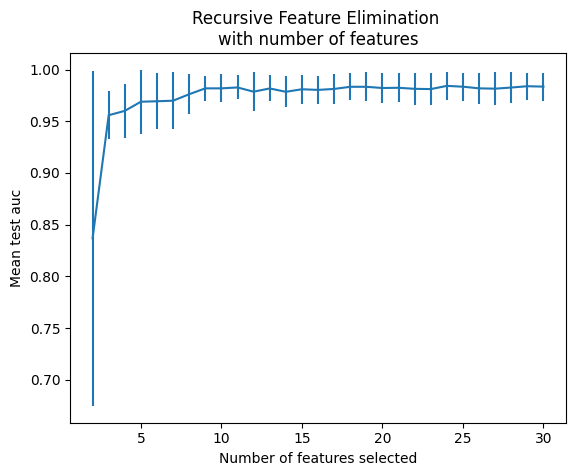

In [139]:
# plot the RFE process
feature_selector.feature_score_plot()

In [144]:
X_selected = X.loc[:,selected_features]
X_selected.head()

,mean radius,mean texture,mean perimeter,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,...,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry
0,17.99,10.38,122.80,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,...,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601
1,20.57,17.77,132.90,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,...,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750
2,19.69,21.25,130.00,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,...,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613
3,11.42,20.38,77.58,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,...,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638
4,20.29,14.34,135.10,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,...,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364


### Feature Selector in the ML Pipeline

This feature selector then can be used in an ML Pipeline. For example, we can test its robustness under [nested_cross_validation](https://github.com/MenaWANG/ML_toy_examples/blob/main/tune%20models/nested_CV.ipynb)

In [141]:
def nested_cv_feature_selection(X, y, estimator, feature_selector, scorer, cv_outer):
    """
    Perform nested cross-validation for feature selection.
    """
    nested_scores = []
    selected_features = []

    for i, (train_idx, test_idx) in enumerate(cv.split(X,y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Perform feature selection using the inner cross-validation
        selected_feature_indices, inner_scores = feature_selector.select_features(X_train, y_train)
        # Train the estimator on the selected features
        estimator.fit(X_train.loc[:, selected_feature_indices], y_train)
        # Evaluate the estimator on the test set
        score = scorer(estimator, X_test.loc[:, selected_feature_indices], y_test)

        nested_scores.append(score)
        selected_features.append(selected_feature_indices)

    return nested_scores, selected_features

# Example usage
if __name__ == '__main__':
    # Create a sample dataset for demonstration
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns = data.feature_names)
    y = data.target
    
    # Define outer and inner cross-validation strategies
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # Initialize the FeatureSelector with an estimator, scoring and cv option
    feature_selector = FeatureSelector(estimator=lgb.LGBMClassifier(verbose=-1), 
                                       min_features_to_select=2,
                                       step = 1,
                                       scoring = custom_scorer,
                                       cv = cv_inner)
    
    # Perform nested cross-validation with above configuration
    nested_scores, selected_features_list = nested_cv_feature_selection(X, y, estimator, feature_selector, 
                                                               scorer = custom_scorer,
                                                               cv_outer = cv_outer)

    print("Nested cross-validation scores:", nested_scores)
    # print("Selected features for fold 0:", X.loc[:,selected_features[0]].columns)


Nested cross-validation scores: [0.9936087110900698, 0.9313528228192687, 0.9879951980792319]


In [142]:
# Get the names of the features from X.columns
feature_names = X.columns

# Initialize a dictionary to track the count of each feature
feature_counts = {feature: 0 for feature in feature_names}

# Iterate through the list of selected features for each fold
for selected_features in selected_features_list:
    for i, is_selected in enumerate(selected_features):
        if is_selected:
            feature_counts[feature_names[i]] += 1

# Create a DataFrame from the feature counts
df = pd.DataFrame({'feature_name': list(feature_counts.keys()), 
                   'selection_count': list(feature_counts.values())})

# Print the resulting DataFrame
print(df.sort_values(by='selection_count', ascending=False))


               feature_name  selection_count
27     worst concave points                3
7       mean concave points                3
22          worst perimeter                3
21            worst texture                3
20             worst radius                3
1              mean texture                3
0               mean radius                2
18           symmetry error                2
26          worst concavity                2
24         worst smoothness                2
23               worst area                2
10             radius error                2
13               area error                2
28           worst symmetry                1
25        worst compactness                1
19  fractal dimension error                1
15        compactness error                1
11            texture error                1
8             mean symmetry                1
6            mean concavity                1
5          mean compactness                1
4         

What I really like about the above efforts
1. How cv, scorer, estimator are customized outside and then passed into feature_selector and nested_cv. 
2. Because of 1, the feature selector is configured outside of nested_cv, and within nested_cv it only takes X and y as input

Next iteration, considering what we want nested_cv_feature_selection to do. Currently it is an independent function, do we want to make it into a class that returns the features selected? Or stay as a diagnostic tool? Either way, some functionalities can be added, say above adding abilities to show the number of times featues selected for each folds. 